This notebook deals with the classification of resistors, using the color classifier and more



In [124]:
# Bootstrap
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import joblib
from sklearn.svm import SVC
import cv2 as cv

LABEL_PLOT_MAP = {
    "Black": "black",
    "Brown": "saddlebrown",
    "Red": "red",
    "Orange": "orange",
    "Yellow": "yellow",
    "Green": "limegreen",
    "Blue": "blue",
    "Purple": "purple",
    "Grey": "gray",
    "Silver": "silver",
    "Gold": "gold",
    "White": "white",
    "Noise": "pink",
    "_Unknown": "pink"
}

COLOR_RGB_MAP = {
    "black": (0, 0, 0),
    "saddlebrown": (139, 69, 19),
    "red": (255, 0, 0),
    "orange": (255, 165, 0),
    "yellow": (255, 255, 0),
    "limegreen": (50, 205, 50),
    "blue": (0, 0, 255),
    "purple": (128, 0, 128),
    "gray": (128, 128, 128),
    "silver": (192, 192, 192),
    "gold": (255, 185, 0),
    "white": (255, 255, 255),
    "pink": (255, 192, 203)
}

def load_preprocessed_img(filename:str ):
    return cv.imread("./data/labelling/"+filename)

CLF = SVC()
CLF = joblib.load('models/clf_CbCrSY_20230724.pkl')
LABEL_ENCODER = joblib.load('models/label_encoder.pkl')
# Get the label mapping
label_mapping = {i: label for i, label in enumerate(LABEL_ENCODER.inverse_transform(range(len(LABEL_ENCODER.classes_))))}
LABEL_COLOR_MAP = {key: LABEL_PLOT_MAP[value] for key, value in label_mapping.items()}

# Options
smoothing_window_size = 41  # Bigger smoothing window = bigger effect 
window_size_for_extrema = 28  # Bigger windowsz = lesser critical points
consensus_width = 41 # Critical points between colorspaces within this width agree with each other
min_distance = 30
roi_pad = 35
overlapping_width = 25

# TEST_FILE = "brown-black-black-red-brown-8.jpg"
# TEST_FILE = "brown-black-black-orange-brown-8.jpg"
# TEST_FILE = "green-blue-silver-gold-5.jpg"
# TEST_FILE = "green-blue-silver-gold-9.jpg"
# TEST_FILE = "red-purple-silver-gold-2.jpg"
# TEST_FILE = "red-purple-silver-gold-3.jpg"
# TEST_FILE = "red-purple-silver-gold-4.jpg"
# TEST_FILE = "red-purple-silver-gold-6.jpg"
# TEST_FILE = "red-purple-silver-gold-8.jpg"
# TEST_FILE = "yellow-purple-silver-gold-2.jpg"
# TEST_FILE = "yellow-purple-silver-gold-4.jpg"
# TEST_FILE = "yellow-purple-silver-gold-6.jpg"
# TEST_FILE = "yellow-purple-silver-gold-10.jpg"
# TEST_FILE = "brown-green-silver-gold-1.jpg"
# TEST_FILE = "brown-green-silver-gold-4.jpg"
# TEST_FILE = "brown-green-silver-gold-6.jpg"
# TEST_FILE = "brown-green-silver-gold-7.jpg"
# TEST_FILE = "green-blue-silver-gold-4.jpg"
# TEST_FILE = "green-blue-silver-gold-7.jpg"
# TEST_FILE = "orange-white-silver-gold-0.jpg"
# TEST_FILE = "orange-white-silver-gold-5.jpg"
# TEST_FILE = "orange-white-silver-gold-12.jpg"
# TEST_FILE = "orange-white-silver-gold-20.jpg"
TEST_FILE = "blue-grey-silver-gold-6.jpg" # GOOD
# TEST_FILE = "blue-grey-silver-gold-8.jpg"
# TEST_FILE = "blue-grey-silver-gold-9.jpg"
# TEST_FILE = "blue-grey-silver-gold-11.jpg"
# TEST_FILE = "blue-grey-silver-gold-17.jpg"
# TEST_FILE = "blue-grey-silver-gold-18.jpg"
# TEST_FILE = "blue-grey-silver-gold-19.jpg"
img = load_preprocessed_img(TEST_FILE)

In [125]:
# ----- HELPER FUNCTIONS FOR PREDICTION -----

def filter_columns(mat, selected_columns):
    return mat.loc[:, selected_columns]

# Takes in a psuedo-1D image, slices and populates a dataframe with its approprate values 
def get_1D_slice(img: cv.Mat):
    lab_image = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    # Extract LAB color channels
    L, a, b = cv.split(lab_image)
    # Convert the BGR image to YCrCb color space
    ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

    # Extract YCrCb color channels
    Y, Cr, Cb = cv.split(ycrcb_image)

    # Convert the BGR image to HSV color space
    hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Extract HSV color channels
    H, S, V = cv.split(hsv_image)

    # Get the image width and create the x-axis coordinate column
    width = img.shape[1]
    col = list(range(0, width))
    # Extract only the first row from each colorspace
    L = L[0, :]
    a = a[0, :]
    b = b[0, :]
    Y = Y[0, :]
    Cr = Cr[0, :]
    Cb = Cb[0, :]
    H = H[0, :]
    S = S[0, :]
    V = V[0, :]

    data = {
        'col': col,
        'L': L.flatten(),
        'a': a.flatten(),
        'b': b.flatten(),
        'R': img[0, :, 2].flatten(),
        'G': img[0, :, 1].flatten(),
        'B': img[0, :, 0].flatten(),
        'Y': Y.flatten(),
        'Cr': Cr.flatten(),
        'Cb': Cb.flatten(),
        'H': H.flatten(),
        'S': S.flatten(),
        'V': V.flatten()
    }

    df = pd.DataFrame(data)
    # print(df)
    return df


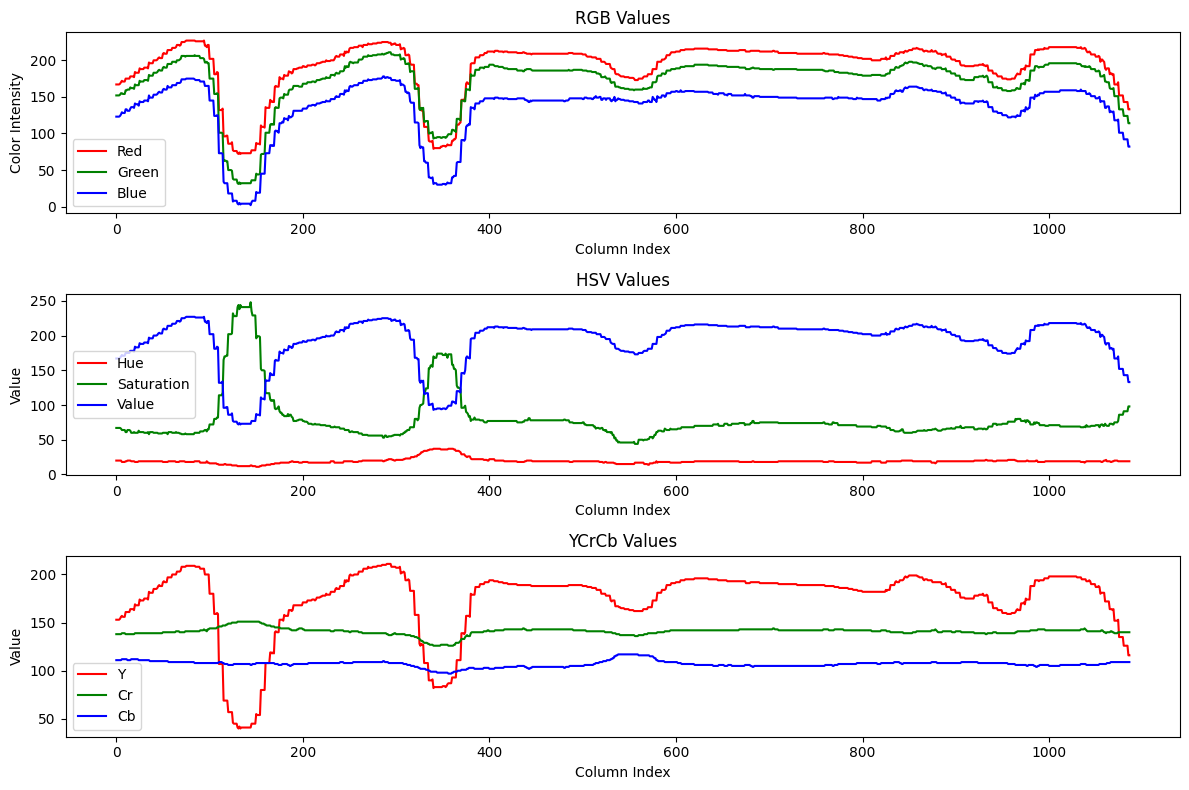

In [126]:
# ----- EXPLORATORY PLOTTING OF COLORSPACE VALUES -----

def plot_color_values(image, row_idx):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    ycrcb_image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)

    hsv_row = hsv_image[row_idx, :, :]
    ycrcb_row = ycrcb_image[row_idx, :, :]
    rgb_row = image[row_idx, :, :]

    # Split RGB channels
    r_values = rgb_row[:, 2]
    g_values = rgb_row[:, 1]
    b_values = rgb_row[:, 0]

    # Split HSV channels
    h_values = hsv_row[:, 0]
    s_values = hsv_row[:, 1]
    v_values = hsv_row[:, 2]

    # Split YCrCb channels
    y_values = ycrcb_row[:, 0]
    cr_values = ycrcb_row[:, 1]
    cb_values = ycrcb_row[:, 2]

    plt.figure(figsize=(12, 8))

    # RGB plot
    plt.subplot(3, 1, 1)
    plt.plot(r_values, color='r', label='Red')
    plt.plot(g_values, color='g', label='Green')
    plt.plot(b_values, color='b', label='Blue')
    plt.title('RGB Values')
    plt.xlabel('Column Index')
    plt.ylabel('Color Intensity')
    plt.legend()

    # HSV plot
    plt.subplot(3, 1, 2)
    plt.plot(h_values, color='r', label='Hue')
    plt.plot(s_values, color='g', label='Saturation')
    plt.plot(v_values, color='b', label='Value')
    plt.title('HSV Values')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.legend()

    # YCrCb plot
    plt.subplot(3, 1, 3)
    plt.plot(y_values, color='r', label='Y')
    plt.plot(cr_values, color='g', label='Cr')
    plt.plot(cb_values, color='b', label='Cb')
    plt.title('YCrCb Values')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_color_values(img, 0)

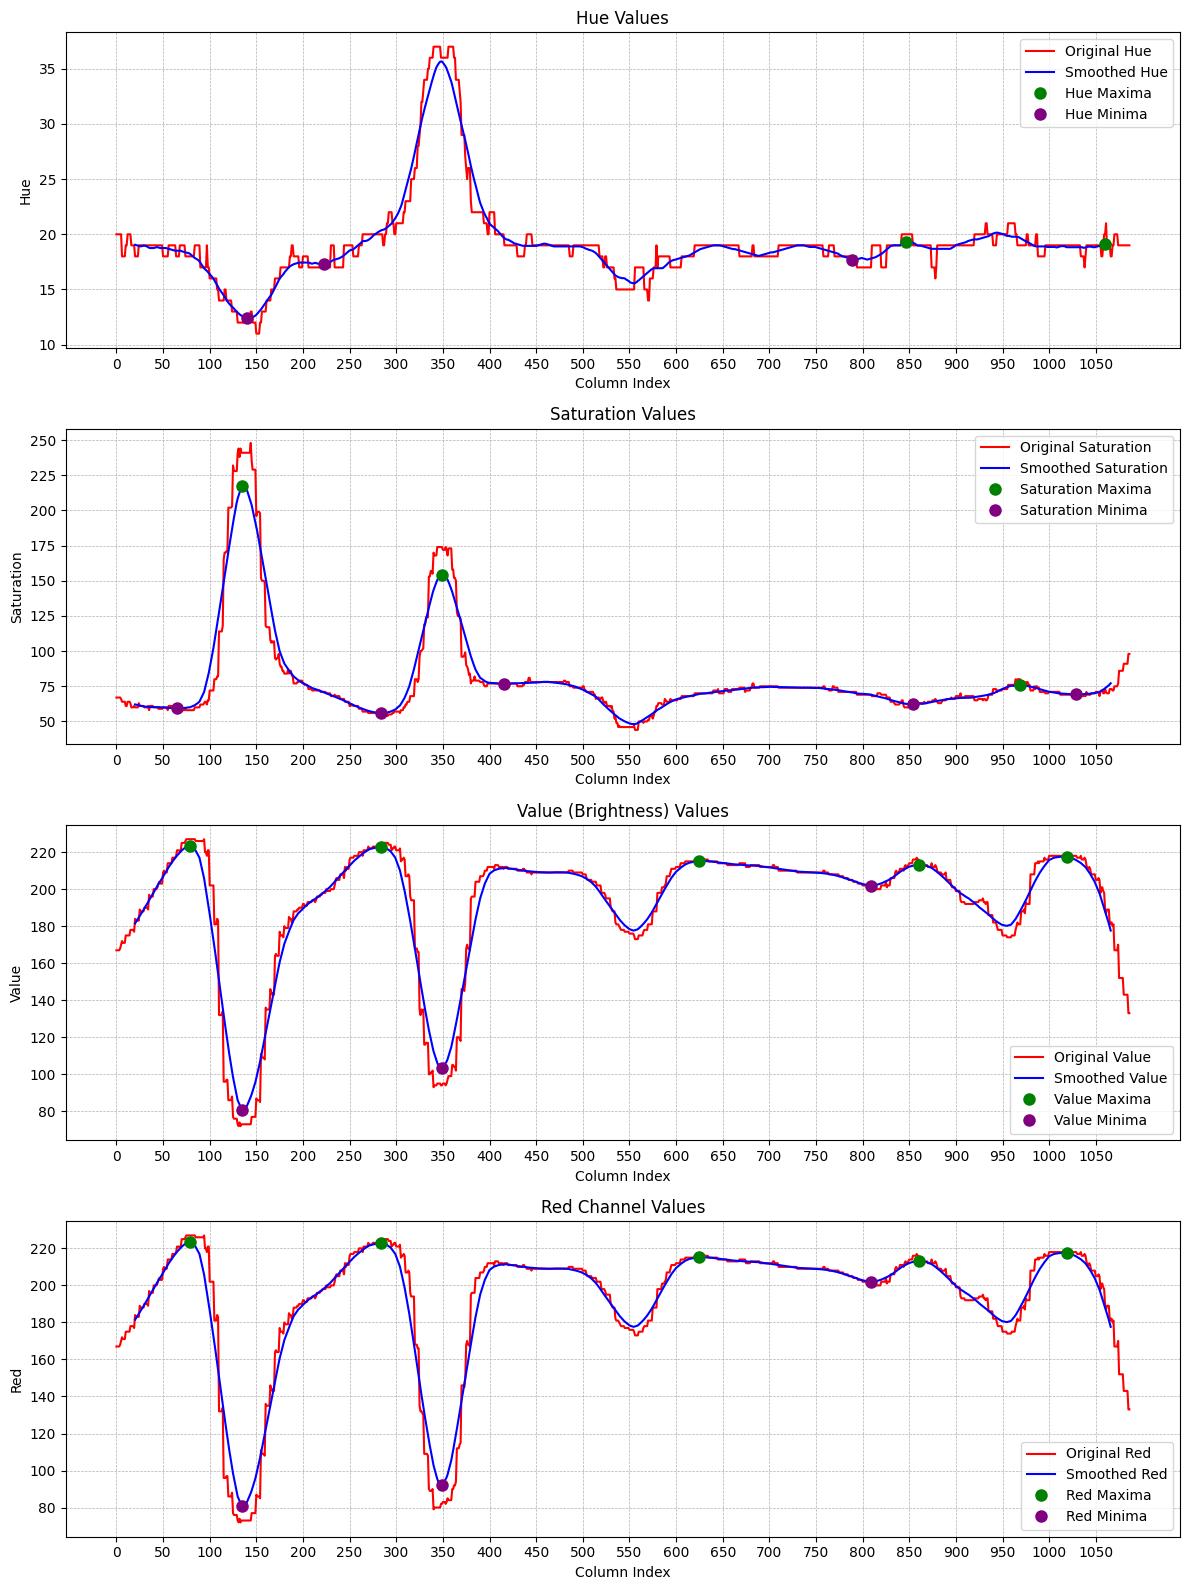

In [127]:
# ----- REGION OF INTEREST MATH FUNCTIONS AND PLOTS -----
from scipy.misc import derivative
from scipy.signal import argrelextrema

def smooth_data(data, window_size):
    # Use a simple moving average for smoothing
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


# ---- ARGRELEXTREMA ----
def find_local_maxima(data, window_size):
    # Find local maxima within the specified window size
    return argrelextrema(data, np.greater, order=window_size)[0]

def find_local_minima(data, window_size):
    # Find local minima within the specified window size
    return argrelextrema(data, np.less, order=window_size)[0]

# ---- FIND_PEAKS ----
# from scipy.signal import find_peaks
# def find_local_maxima(data, window_size):
#     return find_peaks(data, distance=window_size)[0]

# def find_local_minima(data, window_size):
#     return find_peaks(-data, distance=window_size)[0]

# ----- PEAKUTILS -----
# import peakutils

# def find_local_maxima(data, window_size):
#     return peakutils.indexes(data, thres=0.2, min_dist=window_size)

# def find_local_minima(data, window_size):
#     return peakutils.indexes(-data, thres=0.2, min_dist=window_size)


def plot_hsv_values(image, row_idx, smoothing_window=smoothing_window_size, window_size_for_extrema=window_size_for_extrema):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hsv_row = hsv_image[row_idx, :, :]

    h_values = hsv_row[:, 0]
    s_values = hsv_row[:, 1]
    v_values = hsv_row[:, 2]

    # Smooth the HSV values using the specified window size
    smoothed_h = smooth_data(h_values, smoothing_window)
    smoothed_s = smooth_data(s_values, smoothing_window)
    smoothed_v = smooth_data(v_values, smoothing_window)

    # Find local maxima and minima in the smoothed data
    h_maxima = find_local_maxima(smoothed_h, window_size_for_extrema)
    h_minima = find_local_minima(smoothed_h, window_size_for_extrema)

    s_maxima = find_local_maxima(smoothed_s, window_size_for_extrema)
    s_minima = find_local_minima(smoothed_s, window_size_for_extrema)

    v_maxima = find_local_maxima(smoothed_v, window_size_for_extrema)
    v_minima = find_local_minima(smoothed_v, window_size_for_extrema)

    # Smooth the Red channel values using the specified window size
    red_channel = image[row_idx, :, 2]
    smoothed_red = smooth_data(red_channel, smoothing_window)

    # Find local maxima and minima in the smoothed Red channel data
    red_maxima = find_local_maxima(smoothed_red, window_size_for_extrema)
    red_minima = find_local_minima(smoothed_red, window_size_for_extrema)

    plt.figure(figsize=(12, 16))

    # Hue plot
    plt.subplot(4, 1, 1)
    plt.plot(h_values, color='r', label='Original Hue')
    plt.plot(np.arange(smoothing_window // 2, len(smoothed_h) + smoothing_window // 2), smoothed_h, color='b', label='Smoothed Hue')

    # Plot local maxima and minima
    plt.plot(h_maxima + smoothing_window // 2, smoothed_h[h_maxima], 'o', markersize=8, color='g', label='Hue Maxima')
    plt.plot(h_minima + smoothing_window // 2, smoothed_h[h_minima], 'o', markersize=8, color='purple', label='Hue Minima')

    plt.title('Hue Values')
    plt.xlabel('Column Index')
    plt.ylabel('Hue')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, len(h_values), 50))

    # Saturation plot
    plt.subplot(4, 1, 2)
    plt.plot(s_values, color='r', label='Original Saturation')
    plt.plot(np.arange(smoothing_window // 2, len(smoothed_s) + smoothing_window // 2), smoothed_s, color='b', label='Smoothed Saturation')

    # Plot local maxima and minima
    plt.plot(s_maxima + smoothing_window // 2, smoothed_s[s_maxima], 'o', markersize=8, color='g', label='Saturation Maxima')
    plt.plot(s_minima + smoothing_window // 2, smoothed_s[s_minima], 'o', markersize=8, color='purple', label='Saturation Minima')

    plt.title('Saturation Values')
    plt.xlabel('Column Index')
    plt.ylabel('Saturation')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, len(s_values), 50))

    # Value plot
    plt.subplot(4, 1, 3)
    plt.plot(v_values, color='r', label='Original Value')
    plt.plot(np.arange(smoothing_window // 2, len(smoothed_v) + smoothing_window // 2), smoothed_v, color='b', label='Smoothed Value')

    # Plot local maxima and minima
    plt.plot(v_maxima + smoothing_window // 2, smoothed_v[v_maxima], 'o', markersize=8, color='g', label='Value Maxima')
    plt.plot(v_minima + smoothing_window // 2, smoothed_v[v_minima], 'o', markersize=8, color='purple', label='Value Minima')

    plt.title('Value (Brightness) Values')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, len(v_values), 50))

    # Red (R) channel plot
    plt.subplot(4, 1, 4)
    plt.plot(red_channel, color='r', label='Original Red')
    plt.plot(np.arange(smoothing_window // 2, len(smoothed_red) + smoothing_window // 2), smoothed_red, color='b', label='Smoothed Red')

    # Plot local maxima and minima
    plt.plot(red_maxima + smoothing_window // 2, smoothed_red[red_maxima], 'o', markersize=8, color='g', label='Red Maxima')
    plt.plot(red_minima + smoothing_window // 2, smoothed_red[red_minima], 'o', markersize=8, color='purple', label='Red Minima')

    plt.title('Red Channel Values')
    plt.xlabel('Column Index')
    plt.ylabel('Red')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, len(red_channel), 50))

    plt.tight_layout()
    plt.show()

plot_hsv_values(img, 0)
# plot_derivative(img, 0)

In [128]:
# ----- REGION OF INTEREST GENERATION -----

# For a given colorspace metric, there may be critical points very close to each other
# This causes false positives (2 votes when there is really only one)
# For close points, take the average value
# Use if not using ARGRELEXTREMA
def remove_overlapping_points(values, window_threshold=overlapping_width):
    if len(values) <= 0:
        return values
    # The values should be in ASC order
    filtered = []
    current_group = [values[0], values[0]] # keep max min reference
    for value in values:
        if abs(value - current_group[0]) <= window_threshold:
            # value is within range.
            current_group[-1] = max(value, current_group[0]) # redundancy
        else:
            # new group
            filtered.append(np.mean(current_group))
            current_group.clear()
            current_group.extend([value, value])
    filtered.append(np.mean(current_group))
    return filtered

def get_critical_points(image, smoothing_window=smoothing_window_size, window_size_for_extrema=window_size_for_extrema):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hsv_row = hsv_image[0, :, :]

    h_values = hsv_row[:, 0]
    s_values = hsv_row[:, 1]
    v_values = hsv_row[:, 2]

    # Smooth the HSV values using the specified window size
    smoothed_h = smooth_data(h_values, smoothing_window)
    smoothed_s = smooth_data(s_values, smoothing_window)
    smoothed_v = smooth_data(v_values, smoothing_window)

    # Find local maxima and minima in the original data
    # Find local maxima and minima in the smoothed data
    h_maxima = find_local_maxima(smoothed_h, window_size_for_extrema)
    # h_minima = find_local_minima(smoothed_h, window_size_for_extrema)

    s_maxima = find_local_maxima(smoothed_s, window_size_for_extrema)
    s_minima = find_local_minima(smoothed_s, window_size_for_extrema)

    v_maxima = find_local_maxima(smoothed_v, window_size_for_extrema)
    v_minima = find_local_minima(smoothed_v, window_size_for_extrema)

    # Smooth the Red channel values using the specified window size
    red_channel = image[0, :, 2]
    smoothed_red = smooth_data(red_channel, smoothing_window)

    # Find local maxima and minima in the original Red channel data
    # red_maxima = find_local_maxima(smoothed_red, window_size_for_extrema)
    red_minima = find_local_minima(smoothed_red, window_size_for_extrema)

    # Store the true column indices of argmax and argmin points in separate arrays
    # H_points = np.concatenate((h_maxima, h_minima))
    H_points = h_maxima
    S_points = np.concatenate((s_maxima, s_minima))
    # S_points = s_maxima
    V_points = np.concatenate((v_maxima, v_minima))
    # V_points = v_minima
    # R_points = np.concatenate((red_maxima, red_minima))
    R_points = red_minima

    # Remove overlaps if not using ARGRELEXTREMA
    H_points = remove_overlapping_points(H_points)
    S_points = remove_overlapping_points(S_points)
    V_points = remove_overlapping_points(V_points)
    R_points = remove_overlapping_points(R_points)
    return [H_points, S_points, V_points, R_points]
    

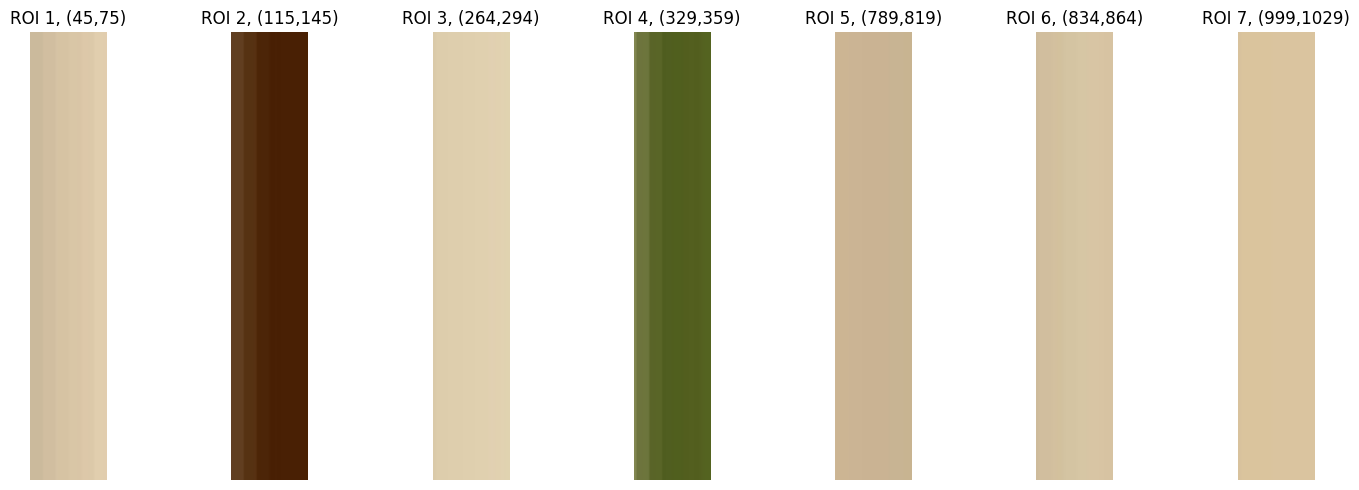

In [129]:
# ----- REGION OF INTEREST FINETUNING -----

# If > 1 critical point are within threshold range of each other, they form a consenus
# that region is a place of interst
def get_consensus_roi(setA, setB, setC, consensus_width=consensus_width, roi_padding=30):
    data = np.concatenate([setA, setB, setC])
    sorted_data = np.sort(data)
    # print(sorted_data)
    rois = []
    roi = []
    prev = sorted_data[0] - consensus_width - 1  # Initialize prev to a value smaller than the minimum data value
    for point in sorted_data:
        if point - prev > consensus_width:
            if len(roi) > 1:
                rois.append(roi)
            roi = [point]
            prev = point
        else:
            roi.append(point)
    if len(roi) > 1:
        rois.append(roi)
    # print(rois)
    # For each ROI range, get its average and pad it 
    roi_ans = []
    for roi_pair in rois:
        start = roi_pair[0]
        end = roi_pair[-1]
        avg = int((start+end)/2)
        # roi_ans.append([avg, avg+window_size_for_extrema//2])
        # roi_ans.append([start, start + 33])
        roi_ans.append([start, start + roi_padding])

    return roi_ans

def get_regions_of_interest(img, smooth_win_sz=smoothing_window_size, window_extrema_sz=window_size_for_extrema, consensus_width=consensus_width, padding=30):
    H, S, V, R = get_critical_points(img, smoothing_window=smooth_win_sz, window_size_for_extrema=window_extrema_sz)
    VR = np.concatenate((V, R))
    roi = get_consensus_roi(H, S, VR, consensus_width, padding)
    return roi

# --- FUNCTIONS IN ACTION ---

roi = get_regions_of_interest(img)

# Convert the given column coordinates to integers
roi = np.array(roi, dtype=int)

# Convert the image from BGR to RGB using OpenCV
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Extract and plot each ROI on a single row
num_rois = len(roi)
plt.figure(figsize=(15, 5))  # Adjust the figure size to display all ROIs on a single row

for i, (start_col, end_col) in enumerate(roi):
    # Extract the ROI from the image using array slicing
    roi_image = img_rgb[:, int(start_col):int(end_col), :]
    
    # Plot the ROI
    plt.subplot(1, num_rois, i+1)
    plt.imshow(roi_image)
    plt.title(f"ROI {i+1}, ({start_col},{end_col})")
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


In [130]:
# ----- PREDICTION FUNCTIONS -----

def predict_colors(image, clf: SVC):
    input_df = get_1D_slice(image)
    cols = filter_columns(input_df, ["Cb", "Cr", "S", "Y"])
    res = clf.predict_proba(cols)
    return res

def process_probability(y_pred, threshold:float, label_encoder):
    y_pred_labels = []
    for p_list in y_pred:
        max_prob = np.max(p_list)
        predicted = ''
        if max_prob >= threshold:
            max_prob_index = np.argmax(p_list)
            predicted = max_prob_index
        else:
            predicted = label_encoder.transform(["_Unknown"])[0]
        y_pred_labels.append(predicted)
    return y_pred_labels

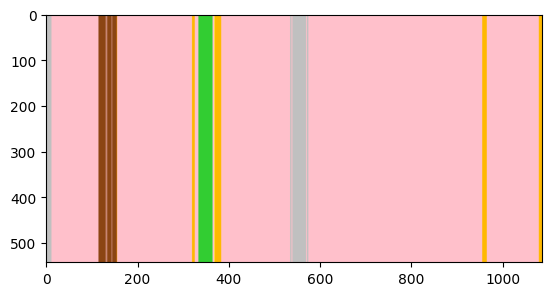

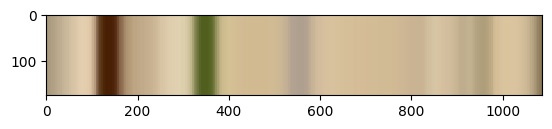

In [131]:
# --- PLOTTING RAW PREDICTIONS ---

prob = predict_colors(img, CLF)
res = process_probability(prob, 0.5, LABEL_ENCODER)
predicted_colors = [LABEL_PLOT_MAP[label_mapping[prediction]] for prediction in res]

# Plotting the predictions
# Image dimensions
num_rows = len(res)//2
num_cols = len(res)

# Create an empty image
predicted_img = np.zeros((num_rows, num_cols, 3), dtype=np.uint8)

# Plot the predictions as an image
for col, prediction in enumerate(res):
    # Get the RGB tuple based on the prediction label
    rgb = COLOR_RGB_MAP.get(LABEL_COLOR_MAP[prediction], (255, 255, 255))  # Default to black if label is not found
    # Set the RGB value for the corresponding row and column in the image
    predicted_img[:, col] = rgb

# Plot the image using plt.imshow()
plt.imshow(predicted_img)
# plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Plot the original image
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img_rgb)
# plt.axis('off')  # Turn off axis labels
plt.show()


In [132]:
# ----- PREDICTION POST-PROCESSING -----

# For each ROI, find the colors
def predict_colors_in_roi(roi, image, clf, label_encoder, threshold=0.5):
    # Image must be in a DF
    # Extract the ROI from the image using array slicing
    start_col, end_col = int(roi[0]), int(roi[1])
    roi_image = image[:, start_col:end_col, :]

    # Predict the colors for the ROI
    prob = predict_colors(roi_image, clf)
    predicted_labels = process_probability(prob, threshold, label_encoder)

    # Count the occurrences of each predicted color label
    label_counts = np.bincount(predicted_labels)

    # Choose the most appeared color label as the final prediction for the ROI
    most_common_label = np.argmax(label_counts)

    # If the most common label is "_Unknown", find the second most common label if available
    if most_common_label == label_encoder.transform(["_Unknown"])[0]:
        # Sort the label counts in descending order
        sorted_counts = np.argsort(label_counts)[::-1]

        # Get the second most common label
        second_most_common_label = sorted_counts[1]

        # Check if the count of the second most common label is greater than a quarter of the total predictions
        if label_counts[second_most_common_label] > len(predicted_labels) / 5:
            most_common_label = second_most_common_label

    most_common_label_name = label_encoder.inverse_transform([most_common_label])[0]

    return most_common_label_name

# returns the predicted color and their ROI center
def predict_colors_for_rois(rois, image, clf, label_encoder, threshold=0.5):
    predicted_colors = []
    for roi in rois:
        predicted_label = predict_colors_in_roi(roi, image, clf, label_encoder, threshold)
        predicted_colors.append([predicted_label, (roi[0]+roi[1])//2 ])
    # predicted_colors = correct_grays(image, predicted_colors)
    return predicted_colors

def correct_grays(image, predictions, gray_threshold=50):
    # Convert the image to HSV color space
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    # Get the V (brightness) values of the specified column
    index = 0
    silvers = [] # [ {index, value}, ... ]
    highest_value = 0
    for color, column in predictions:
        # print(color, column)
        if color == "Silver":
            v = hsv_image[0, int(column), 2] # get the brightness
            highest_value = max(v, highest_value)
            silvers.append([index, v])            
        index += 1
    # Take the highest value as the baseline for silver (lazy heuristic)
    for idx, value in silvers:
        # print(highest_value, value)
        if highest_value - value >= gray_threshold:
            # this silver is darker than expected. correct it to gray
            # print(f"Correcting pred @ {predictions[idx][1]} to Gray")
            predictions[idx][0] = "Grey"
    return predictions
    
# SIMPLIFYING ASSUMPTIONS & HEURISTICS
# We define a resistor here to only have 4 bands
# Define Gold and Silver to be a 'weak' colors
# 1. If a color predicted is NOT weak, it's likely to be correct
# 2. Weak colors between 'likely correct' colors should be discarded unless we cannot hit the band limit
# 3. The first 2 colors cannot be GOLD or SILVER. This is a fact.
# 4. Prefer non-gold non-silver for the last 2 bands
# 5. For the non-first 2 colors, repeated colors (AAAB) should be aggregated to prefer different clors (AB) 
def process_predictions(img, predictions, bands=4, min_distance=120):
    # print(predictions)
    res = [] # index, prediction
    chosen_indexes = []
    # Filter out noise
    index = 0
    for prediction, centroid in predictions:
        # print(index, prediction, centroid, len(res))
        if prediction == "_Unknown" or prediction == "Noise":
            index += 1
            continue
        res.append(index)
        index += 1
    # Filter out too-close WEAK bands, indicative of false positives
    prev_centroid = -2000
    prev_color = ""
    for idx in res:
        # Even if distance is off, IF the color is not weak, add it in
        if predictions[idx][0] != "Silver" or predictions[idx][0] != "Gold":
            chosen_indexes.append(idx)
            prev_color, prev_centroid = predictions[idx]
        elif predictions[idx][1] - prev_centroid >= min_distance:
            chosen_indexes.append(idx)
            prev_color, prev_centroid = predictions[idx]
        if predictions[idx][1] - prev_centroid >= min_distance:
            chosen_indexes.append(idx)
            prev_color, prev_centroid = predictions[idx]
    res.clear() # reuse res
    for idx in chosen_indexes:
        res.append(predictions[idx])
    # Process for misclassfied grays 
    res = correct_grays(img, res)
    # Ensure first 2 colors are non-weak
    index = 0
    while(index < 2 and len(res) > 2):
        # print(index, ":", res)
        if res[index][0] == "Silver" or res[index][0] == "Gold":
            # print("Removing", res[index])
            res.pop(index)
            index -= 1
        index += 1
    # Clean out silver and gold duplicates iff there are too many bands
    prev_color = ""
    final_prediction = []
    if len(res) > bands:
        for color, idx in res:
            if prev_color == color:
                if prev_color == "Silver" or prev_color == "Gold":
                    continue
            prev_color = color
            final_prediction.append(color)
        # If the final_prediction is still too big, chop off the last few
        if len(final_prediction) > bands:
            final_prediction = final_prediction[:bands]
    else:
        for color, _ in res:
            final_prediction.append(color)
    return final_prediction

roi = get_regions_of_interest(img)
predictions = predict_colors_for_rois(roi, img, CLF, LABEL_ENCODER, threshold=0.5)
final_prediction = process_predictions(img, predictions)
final_prediction

['Brown', 'Green']

In [133]:
# ----- RESISTOR COLOR MAPPING TO VALUES -----

BAND_ONE_MAP = {
    "Brown": 1,
    "Red": 2,
    "Orange": 3,
    "Yellow": 4,
    "Green": 5,
    "Blue": 6,
    "Purple": 7,
    "Grey": 8,
    "White": 9
}

BAND_TWO_MAP = {
    "Black": 0,
    "Brown": 1,
    "Red": 2,
    "Orange": 3,
    "Yellow": 4,
    "Green": 5,
    "Blue": 6,
    "Purple": 7,
    "Grey": 8,
    "White": 9
}
# Multiplier
BAND_THREE_MAP = {
    "Black": 1,
    "Brown": 1e1,
    "Red": 1e2,
    "Orange": 1e3,
    "Yellow": 1e4,
    "Green": 1e5,
    "Blue": 1e6,
    "Purple": 1e7,
    "Grey": 1e8,
    "White": 1e9,
    "Gold": 0.1,
    "Silver": 0.01
}
# Tolerance
BAND_FOUR_MAP = {
    "Brown": 1,
    "Red": 2,
    "Orange": 0.05,
    "Yellow": 0.02,
    "Green": 0.5,
    "Blue": 0.25,
    "Purple": 0.1,
    "Grey": 0.01,
    "Gold": 5,
    "Silver": 10
}

In [134]:
# ----- EVALUATION UTIL FUNCTIONS -----
def get_answer(image_name):
    # blue-red-orange-gold-N.jpg --> [blue, red, orange, gold]
    return image_name.split('-')#[:-1]

# Returns the number of correctly identified bands and the list of correct predictions
# (correct, [colors])
def check_answer(answer: list, prediction: list):
    if(len(prediction) == 0):
        return [0, prediction, answer]
    if(len(prediction) > 4):
        print("Too many bands")
    # print(answer)
    colors = []
    num_correct = 0
    idx = 0
    # For each color in prediction
    for color in prediction:
        # print(answer[idx].lower(), color.lower())
        if answer[idx].lower() == color.lower():
            # print("correct")
            num_correct += 1
        idx += 1
    # if num_correct < 3:
    #     print(answer, "is wrong. got:", prediction)
    return num_correct

# Match each color band to their appropriate color
# If len(colors) < 4, perform a best effort estimation
def get_resistance_tolerance_from_value(colors):
    INVALID = "NaN"
    resistance = 0
    tolerance = 0
    if len(colors) < 3:
        return (INVALID, INVALID)
    if BAND_ONE_MAP.get(colors[0]) is None:
        return (INVALID, INVALID)
    resistance = BAND_ONE_MAP[colors[0]]
    resistance *= 10
    resistance += BAND_TWO_MAP[colors[1]]
    resistance *= BAND_THREE_MAP[colors[2]]
    if len(colors) == 4 and BAND_FOUR_MAP.get(colors[3] is not None):
        tolerance = BAND_FOUR_MAP[colors[3]]
    return (resistance, tolerance)   

# Transform ["A", "B", "C", "D"] into compressed "a-b-c-d" form
def tokenize_pred_list(colors):
    ans = ""
    for i, color in enumerate(colors):
        ans += color.lower()
        if i != len(colors) - 1:
            ans += '-'
    return ans


answer = get_answer(TEST_FILE)

In [135]:
# ----- Parallel hyperparameter testing ----
import concurrent.futures

# tasks = []
# # Create and schedule the tasks using concurrent.futures.ProcessPoolExecutor
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     for i in range(26, 51, 2):
#         for j in range(14, 51, 2):
#             for k in range(30, 60, 2):
#                 task = executor.submit(test, i, j, k)
#                 tasks.append(task)

# print(f"Accepted: {correct + partial_correct}/{total}")
# print(f"Perfect: {correct}/{total}")
# print(f"Partial: {partial_correct}/{total}")

def test(smooth_sz, extrema_sz, consensus_sz): 
    smoothing_window_size = smooth_sz
    window_size_for_extrema = extrema_sz
    consensus_width = consensus_sz
    # roi_pad = l
    total = len(images_evaluation)
    correct = 0
    partial_correct = 0 # 3/4 correct 
    answer_results = []
    for image_answer, image, filename in images_evaluation:
        roi = get_regions_of_interest(image, smoothing_window_size, window_size_for_extrema, consensus_width, roi_pad)
        predictions = predict_colors_for_rois(roi, image, CLF, LABEL_ENCODER, threshold=0.5)
        bands_prediction = process_predictions(image, predictions, min_distance=150)
        num_bands_correct,  = check_answer(image_answer, bands_prediction)
        answer_results.append(num_bands_correct)
    # Summary statistics for debugging
    print("---------------------------")
    for v in answer_results:
        if v == 4:
            correct += 1
        elif v == 3:
            partial_correct += 1
    return f"Accepted: {correct + partial_correct}/{total}, {smooth_sz}, {extrema_sz}, {consensus_width}"


# Collect the results
# results = []
# for task in concurrent.futures.as_completed(tasks):
#     result = task.result()
#     results.append(result)
#     # print(result)
#     # Write the results to a text file
# with open('results.txt', 'w') as file:
#     print("Writing results...")
#     for result in results:
#         file.write(result + '\n')
# print("Done!")


In [136]:
# ---- END TO END DEMONSTRATION -----
import os

# --- Best options using relarg, HSVR ----
smoothing_window_size = 41  # Bigger smoothing window = bigger effect 
window_size_for_extrema = 28  # Bigger windowsz = lesser critical points
consensus_width = 41 # Critical points between colorspaces within this width agree with each other
overlapping_width = 20 # In a single colorspace, how close are overlapping values?
min_distance = 30
roi_pad = 35

print("Loading data for evaluation...")
images_evaluation = [] #[ [answer, image] ]
directory = "data/labelling"
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(directory, filename)
        image_data = cv.imread(image_path)
        image_answer = get_answer(filename) 
        if image_data is not None and len(image_answer) == 5: #TODO change
            images_evaluation.append([image_answer, image_data, filename])

print("Beginning testing...")

def predict_resistor(smooth_sz, extrema_sz, consensus_sz):
    columns= ['filename', 'color_predict', 'correct_colors', 'resistance_predict', 'tolerance_predict']
    df = pd.DataFrame(columns=columns)
    
    smoothing_window_size = smooth_sz
    window_size_for_extrema = extrema_sz
    consensus_width = consensus_sz
    # roi_pad = l
    total = len(images_evaluation)
    correct = 0
    partial_correct = 0 # 3/4 correct 
    answer_results = []
    for image_answer, image, filename in images_evaluation:
    
        roi = get_regions_of_interest(image, smoothing_window_size, window_size_for_extrema, consensus_width, roi_pad)
        predictions = predict_colors_for_rois(roi, image, CLF, LABEL_ENCODER, threshold=0.5)
        bands_prediction = process_predictions(image, predictions, min_distance=150)
        predict_resistance, predict_tol = get_resistance_tolerance_from_value(bands_prediction)
        num_bands_correct = check_answer(image_answer, bands_prediction)
        bands_prediction_str = tokenize_pred_list(bands_prediction)
        df.loc[len(df)] = [filename, bands_prediction_str, num_bands_correct, predict_resistance, predict_tol]
        answer_results.append(num_bands_correct)
    # Summary statistics for debugging
    print("---------------------------")
    for v in answer_results:
        if v == 4:
            correct += 1
        elif v == 3:
            partial_correct += 1
    print(f"Accepted: {correct + partial_correct}/{total}, {smooth_sz}, {extrema_sz}, {consensus_width}")
    # return f"Accepted: {correct + partial_correct}/{total}, {smooth_sz}, {extrema_sz}, {consensus_width}"
    return df

final_df = predict_resistor(smoothing_window_size, window_size_for_extrema, consensus_width)
final_df.to_csv("results/final_evaluation.csv")

Loading data for evaluation...
Beginning testing...
---------------------------
Accepted: 54/90, 41, 28, 41


In [137]:
# ----- Results Analysis ---- KIV